<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/01_DataScienceUsingPython/blob/main/02_Advanced/04_ImplementingNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression: Implementing a Neural Network using Numpy

In this course, we will learn how a Neural Network works. For this end, we will implement a very simple Neural Network using Numpy. First, we will understand our data, and understand which are our explicative and target features. Then, we will learn how each part of the Neural Network functions, and how to fit our Neural Network by optimizing the model parameters.

For this end, we will use the following packages:

In [323]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

Also, we will use the following dataset:

In [324]:
df = pd.read_csv('Bicicletas.csv')

df.head( )

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


So, we have information about the climate, the temperature, and the number of bikes rented. Also, we have 731 entries in our dataset:

In [325]:
df.shape

(731, 3)

## Understanding our dataset

First, let's understand our dataset a little more. We are interested with the number of bikes being rented. Thus, let's see how does it change with the change in temperature:

In [326]:
plt.rcParams.update({'figure.figsize': (14, 6)})
plt.rcParams.update({'font.size': 14})

Text(0.5, 0, 'temperature')

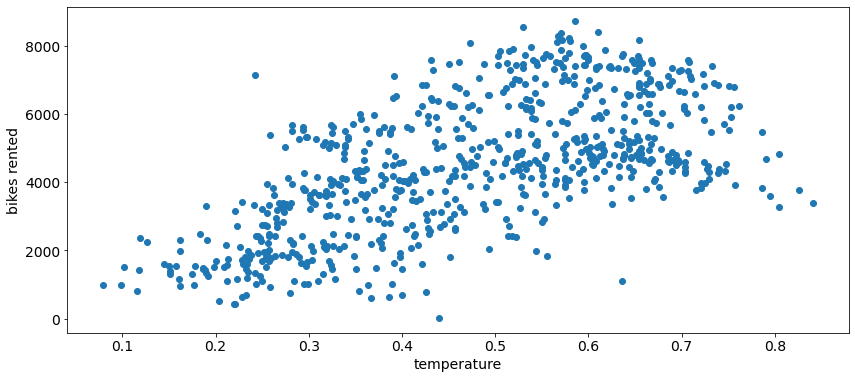

In [327]:
plt.scatter(df['temperatura'], df['bicicletas_alugadas'])
plt.ylabel('bikes rented')
plt.xlabel('temperature')

It seems that the number of bikes being rented increases as the temperature increases.

Now, let's see how the climate variable affects the number of bikes rented:

Text(0.5, 0, 'climate')

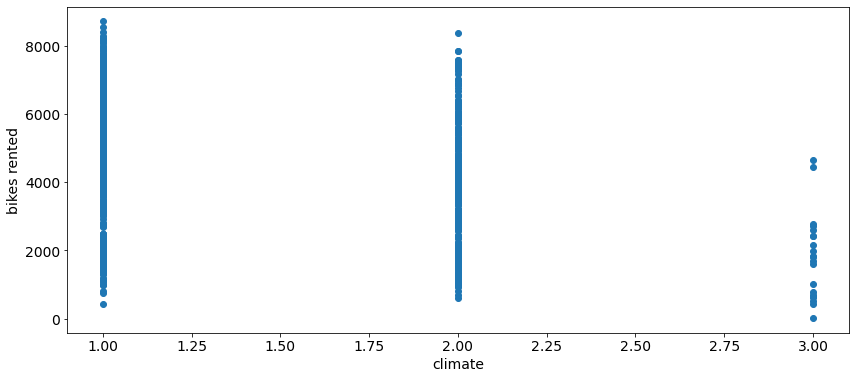

In [328]:
plt.scatter(df['clima'], df['bicicletas_alugadas'])
plt.ylabel('bikes rented')
plt.xlabel('climate')

Climate is actually a categorical variable. It seems that climate 3 is related to a fewer number of rents, and climates 1 and 2 have more rents. 

Now, let's try to plot the number of bikes rented by the temperature, but let's use a different color based on climate:

Text(0.5, 0, 'temperature')

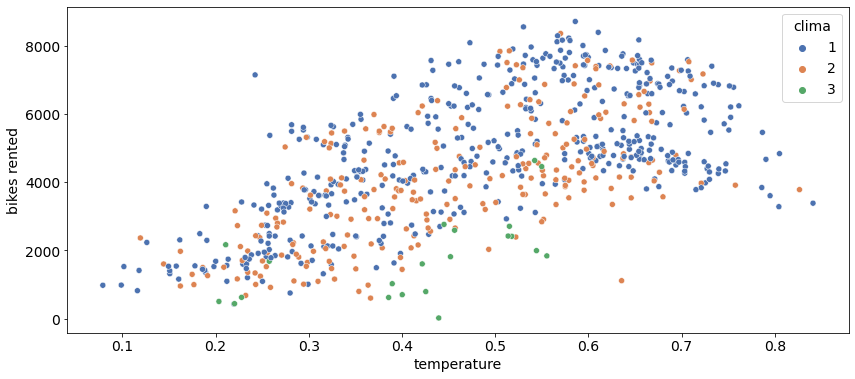

In [329]:
sns.scatterplot(x = 'temperatura', y = 'bicicletas_alugadas', hue = 'clima', data = df, palette="deep")
plt.ylabel('bikes rented')
plt.xlabel('temperature')


Before going further into model fitting, let's separate our explicative and target features, and normalize our data. This will help us to make our predictions in the future, as it makes model fitting and optimization easier.

In [330]:
X = df.drop('bicicletas_alugadas', axis = 1).values
y = df.bicicletas_alugadas.values

Here, to scale the values of our features, we will simply divided by the maximum value. Thus, the maximum value of our feature will be 1.

In [331]:
Xmax = np.amax(X, axis = 0)
ymax = np.amax(y, axis = 0)

X = X/Xmax
y = y/ymax

Let's check our features:

In [332]:
X

array([[0.66666667, 0.43242565],
       [0.66666667, 0.42066914],
       [0.33333333, 0.22524188],
       ...,
       [0.66666667, 0.28826395],
       [0.33333333, 0.27553942],
       [0.66666667, 0.26577246]])

In [333]:
y[0:10]

array([0.11303649, 0.09192105, 0.15480835, 0.17925178, 0.18361258,
       0.18430112, 0.17328437, 0.11005279, 0.09433096, 0.15159513])

Nice! It seems to have worked out.

# Creating the Network structure

Here, we have a regression problem, where we want to predict the number of rented bikes based on the climate and temperature change. 

Thus, we will build a Neural Network to predict those values. The Neural Network will have two inputs (our two explicative features. Then, we will give different weights to each feature. We then evaluate the sum of these using:

\begin{equation}
s = \sum_{i = 1}^n x_j \, w_{ij} + b_j
\end{equation}

where $w_i$ is the weight for the $i$-th feature. Also, $b_j$ is the bias for the $j$-th node.

Then, we run $s$ through an activation function ($\text{act}(s)$). These activation functions help us to introduce non-linearity to the problem. An interesting activation function are the sigmoid and relu functions:

In [334]:
def act_sigmoid(s):
  return 1/(1 + np.exp(-s))

def act_relu(s):
  return np.maximum(0, s)

Nice! 

Note that the Neural Networks may have multiple neurons, each located in different layers. If we have a connection between two layers, one with two neurons (input layer) and other with 3 layers, we will have 6 weights, one for each connection. To store those weights, we often use a matrix $3 \times 2$, where $3$ is the size of the second layer, and $2$ is the size of the first layer.

Let's define a list with the architecture of our network:

In [335]:
architecture = [
    {'dim_input' : 2, 'dim_out' : 3, 'activation' : 'relu'},
    {'dim_input' : 3, 'dim_out' : 1, 'activation' : 'sigmoid'}
]

Thus, our Neural Network has an input layer with 2 nodes, a hidden layer with 3 nodes, and an output layer with 1 node. 

Let's define a function to get the initial weights:

In [336]:
def CalcInitialParams(architecture, seed = 99):
  np.random.seed(seed)

  number_of_layers = len(architecture)         # Gets the number of layers (excludes the output layer)

  param_values = {}                            # Initializes the dict with the parameters

  for index, layer in enumerate(architecture):
    index_layer = index + 1

    layer_size_input = layer['dim_input']
    layer_size_out   = layer['dim_out']

    param_values['W' + str(index_layer)] = np.random.randn(layer_size_out, layer_size_input) # This evaluates the initial weigths (random)
    param_values['B' + str(index_layer)] = np.random.randn(layer_size_out)                   # This evaluates the initial bias (random)

  return param_values

Ok. Now, we have the activation functions and the weights and biases for each layer/neuron. Thus, we can make an initial prediction for our Neural Network:

In [337]:
def PropagateLayer(x_old, weights, bias, activation = 'relu'):
  B = np.transpose(np.tile(bias, (x_old.shape[1], 1)))
  s = np.dot(weights, x_old) + B               # S = W.X + B

  x_new = ActivateSum(s, activation)          # X_new = act(S)

  return x_new, s

def ActivateSum(s, activation):
  if activation == 'relu':
    func_act = act_relu                        # If the activation is Relu, call act_relu( )
  elif activation == 'sigmoid':
    func_act = act_sigmoid                     # If the activation is Sigmoid, call act_sigmoid( )
  else:
    raise Exception('Activation function requested not yet implemented or defined in activate_sum( ).')

  return func_act(s)

Note that the weight vector is a $3 \times 2$ matrix, the bias is a $3 \times 1$ matrix, and the input is a $2 \times 1$ matrix. Thus, we were able to write everything is a matrix multiplication!

Now, let's create a function to make propagation in our entire network:

In [338]:
def PropagateNetwork(X, param_values, architecture):
  memory = {}                                                     # Initializes the memory (stores old and new values for X)
  X_new  = X                                                      # Initializes X for the next layer

  for index, layer in enumerate(architecture):
    X_old = X_new                                                 # Initializes X for the current layer
    index_layer = index + 1

    func_act = layer['activation']
    w_curr   = param_values['W' + str(index_layer)]
    b_curr   = param_values['B' + str(index_layer)]

    X_new, s = PropagateLayer(X_old, w_curr, b_curr, func_act)   # Perform layer propagation

    memory["A" + str(index)] = X_old
    memory["Z" + str(index_layer)] = X_new

  return X_new, memory

Finally, let's call our functions:

In [339]:
param_values = CalcInitialParams(architecture, seed = 99)

y_pred, memory = PropagateNetwork(np.transpose(X), param_values, architecture)

Note that $X$ should be a $2 \times n$ matrix, where $n$ is the number of entries. However, now, it is a $n \times 2$ matrix. That's why we start by transposing this value.

Now, to get the prediction for our first value:

In [340]:
y_pred[0][0]*ymax

170.88821309876226

Let's compare it to our true first value:

In [341]:
y[0]*ymax

985.0000000000001

So, we have missed by a lot. Note that, here, we are using random weights and biases. In fact, we need to optimize our weight and bias values in order to get good predictions.

# Optimizing our parameters and fitting our network

To get optimal values for our parameters, we have to first understand what causes our parameters to be optimal. First, we need to define a loss function. This function states how bad our predictions are: the lower it is, the better.

A very common loss function is the binary cross entropy, given by:

\begin{equation}
F(\hat{y}, y) = -(y \log \hat{y} + (1 - y) \, \log(1 - \hat{y}))
\end{equation}

We can implement this function with:


In [342]:
def EvalLossFunction(y_pred, y):
  n = y_pred.shape[1]      # Get the number of features

  loss = (-1/n) * (np.dot(y, np.log(y_pred).T) + np.dot(1 - y, np.log(1 - y_pred).T))   # Evaluating the binary cross entropy

  return np.squeeze(loss)  # Return the loss. Squeeze ensures that we return a scalar

Note that, here, we are dividing everything by the number of entries just to guarantee that our final loss function (given by the sum of the losses for all entries) is normalized.

Now, based on this loss function, we may update our parameters. We can do that using a backpropagation technique.

## Backpropagation

Backpropagation is used to update the parameters of our network. For that end, we need to evaluate the gradient for the loss function, to understand where should we go to reduce our loss. Our new parameter will be evaluated using:

\begin{equation}
  P_1 = P_0 - \alpha \, \nabla_P
\end{equation}

Thus, we can implement the updating of our parameters using:

In [343]:
def UpdateParams(param_values, gradients, architecture, learning_rate):
  for index, layer in enumerate(architecture, 1):
    param_values["W" + str(index)] -= learning_rate*gradients["dW" + str(index)]
    param_values["B" + str(index)] -= learning_rate*gradients["dB" + str(index)]

  return param_values

Nice! But how can we evaluate the gradient for our loss function?

The gradients are the derivative of the cost function by the estimated parameters. The procedure of evaluating the gradientes and updating the parameters is denominated Backpropagation. Thus, let's define a function to perform backpropagation:


In [344]:
def Backpropagation(y_pred, y, memory, param_values, architecture):
  gradients = {}                                  # Initialize the gradients dict

  y = y.reshape(y_pred.shape)                     # Guarantees that both shapes are the same
  dActivated_old = -(np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

  for index_layer_old, layer in reversed(list(enumerate(architecture))):
    index_layer_new = index_layer_old + 1
    activation_func = layer['activation']

    dActivated_curr = dActivated_old

    activated_old = memory["A" + str(index_layer_old)]
    activated_new = memory["Z" + str(index_layer_new)]

    weights = param_values["W" + str(index_layer_new)]
    bias    = param_values["B" + str(index_layer_new)]

    dActivated_old, dweights_old, dbias_old = Backpropagation_Layer(dActivated_curr, weights, bias, activated_new, activated_old, activation_func)

    gradients['dW' + str(index_layer_new)] = dweights_old
    gradients['dB' + str(index_layer_new)] = dbias_old

  return gradients

Nice! Now, we have to define a function that will perform the backpropagation for each layer. Basically, we need to use the derivatives of the loss function, which can be obtained using the chain rule. To get those, the reader is referred to:

https://en.wikipedia.org/wiki/Backpropagation

First, let's implement some functions that will allow us to use our activation functions when backpropagating (derivatives of the activation functions):

In [345]:
def act_sigmoid_back(dActivated, out):
  sig = act_sigmoid(out)
  return dActivated * sig * (1 - sig)

def act_relu_back(dActivated, out):
  dOut = np.array(dActivated, copy = True)
  dOut[dOut <= 0] = 0
  return dOut

Now, we can implement the backpropagation for one layer:

In [346]:
def Backpropagation_Layer(dActivated_curr, weights, bias, activated_new, activated_old, activation_func = "relu"):
  n = activated_old.shape[1]

  if activation_func == "relu":
    func_act_back = act_relu_back
  elif activation_func == "sigmoid":
    func_act_back = act_sigmoid_back
  else:
    raise Exception("Backpropagated activation function not implemented yet.")
    
  dOut_curr = func_act_back(dActivated_curr, activated_new)

  dW_curr   = np.dot(dOut_curr, activated_old.T) / n

  dB_curr   = np.sum(dOut_curr, axis = 1, keepdims = True).T[0] / n

  dActivated_old = np.dot(weights.T, dOut_curr)
  
  return dActivated_old, dW_curr, dB_curr

Our Neural Network, we have the following steps:

1. Define the initial parameters (randomly).
2. Propagate and get initial prediction. Evaluate loss function.
3. Backpropagation (adjust parameters).
4. Propagate and get the new prediction. Evaluate loss function.
5. If no stopping criteria has been met, return to step 3.
6. After the model has been fitted, get the final prediction.

So, we need to define a function to perform the training of our model, storing this entire process of adjusting the model parameters:


In [347]:
def NeuralNetwork_Fit(X_train, X_test, y_train, y_test, architecture, epochs, learning_rate, verbose = 1, interval_epochs_print = 5000, seed = 99):
  param_values = CalcInitialParams(architecture, seed)

  history_cost_train = []
  history_cost_test  = []

  for e in range(1, epochs + 1):
    y_train_pred, memory_train = PropagateNetwork(X_train, param_values, architecture)
    y_test_pred, memory_test   = PropagateNetwork(X_test, param_values, architecture)

    cost_train = EvalLossFunction(y_train_pred, y_train)
    cost_test  = EvalLossFunction(y_test_pred, y_test)

    history_cost_train.append(float(cost_train))
    history_cost_test.append(float(cost_test))

    gradients = Backpropagation(y_train_pred, y_train, memory_train, param_values, architecture)

    param_values = UpdateParams(param_values, gradients, architecture, learning_rate)

    if verbose:
      if ((e % (interval_epochs_print) == 0) or (e == 1)):
        print("Iteration: {:n} - Loss: {:.5f} - Loss test: {:.5f}".format(e, cost_train, cost_test))
  
  history = {'cost_train' : history_cost_train, 'cost_test' : history_cost_test}

  return param_values, history

Note that, here, we are using a train and test sets. Thus, we can separe our explicative and target features using:

In [348]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

Now, let's perform the fitting of our model:

In [349]:
X_train_aux = np.transpose(X_train)
y_train_aux = np.transpose(y_train)
X_test_aux  = np.transpose(X_test)
y_test_aux  = np.transpose(y_test)

architecture = [
    {'dim_input' : 2, 'dim_out' : 3, 'activation' : 'relu'},
    {'dim_input' : 3, 'dim_out' : 1, 'activation' : 'sigmoid'}
]

epochs = 10000

learning_rate = 0.01

param_values, history = NeuralNetwork_Fit(X_train_aux, X_test_aux, y_train_aux, y_test_aux, architecture, epochs, learning_rate)

Iteration: 1 - Loss: 2.60062 - Loss test: 2.45229
Iteration: 5000 - Loss: 0.69210 - Loss test: 0.69383
Iteration: 10000 - Loss: 0.69209 - Loss test: 0.69393


Nice! Note that, at each iteration, our loss for the training set reduces. We can plot this variation:

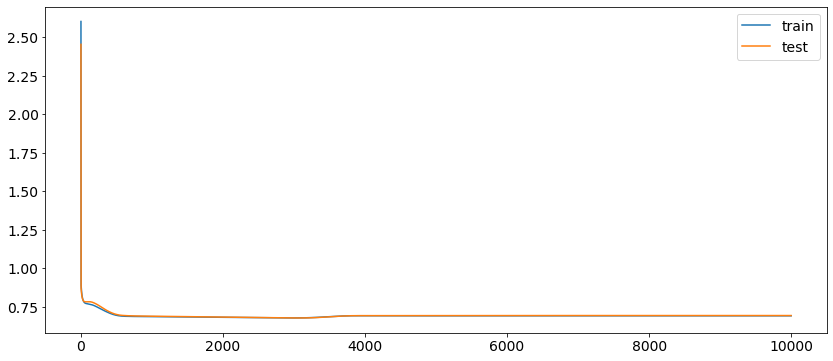

In [350]:
sns.lineplot(x = range(1, 10001), y = history['cost_train'], label = 'train')
sns.lineplot(x = range(1, 10001), y = history['cost_test'], label = 'test')

Nice! Note that the cost for the training and test sets and very similar. 